# Hyper Parameters

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 4000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------
feel_count=16
feel_embd=32
# ------------


torch.manual_seed(1337)

# Data loading

In [2]:
from google.colab import drive
drive.mount('/content/drive')
with open("/content/drive/MyDrive/LLm fighthing/karamazov.txt", "r", encoding="utf-8") as f:
  text=f.read()

Mounted at /content/drive


#Creating the dataset, Encoder, Decoder


In [3]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


#Model


In [4]:
# The feel stuff
class FeelHead(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.key = nn.Linear(feel_embd, head_size, bias=False)

        self.value = nn.Linear(feel_embd, head_size, bias=False)

        self.feelings = torch.rand(feel_count, feel_embd).to(device)

        #self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        q = self.query(x) # (B,T,C)

        k = self.key(self.feelings) # (f_cnt, C)
        k = k.expand(B, -1,-1) # (B, F_cnt, C)

        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, F_cnt) -> (B, T, F_cnt)
        #wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, )
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(self.feelings) # (f_cnt, C)
        v = v.expand(B,-1,-1) # (B, F_cnt, C)
        out = wei @ v # (B, T, F_cnt) @ (B, F_cnt, C) -> (B, T, C)
        return out


class MultiHeadFeeling(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([FeelHead(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

In [5]:
class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, model_type):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ln1 = nn.LayerNorm(n_embd)

        self.ffwd = FeedFoward(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

        self.model_type=model_type
        if model_type=='feel':
          self.mh_feel=MultiHeadFeeling(n_head, head_size)
          self.ln3 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        if self.model_type=='feel':
          x = x + self.mh_feel(self.ln3(x))
        x = x + self.ffwd(self.ln2(x))
        return x


# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self, model_type):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head, model_type=model_type) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

#model = BigramLanguageModel().to(device)
#m = model.to(device)
# print the number of parameters in the model
#print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')



#Training and loss estimation functions


In [6]:
@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# create a PyTorch optimizer
def get_optimizer(model):
  return torch.optim.AdamW(model.parameters(), lr=learning_rate)

def train_model(model, optimizer, history):
  for iter in range(max_iters):

      # every once in a while evaluate the loss on train and val sets
      if iter % eval_interval == 0 or iter == max_iters - 1:
          losses = estimate_loss(model)
          print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
          history['train'].append(losses['train'])
          history['val'].append(losses['val'])

      # sample a batch of data
      xb, yb = get_batch('train')

      # evaluate the loss
      logits, loss = model(xb, yb)
      optimizer.zero_grad(set_to_none=True)
      loss.backward()
      optimizer.step()

def generate_from_model(m):
  # generate from the model
  context = torch.zeros((1, 1), dtype=torch.long, device=device)
  print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


#Plotting and comparisions

In [7]:
history_regular={
  'train':[],
  'val':[]
}
history_feel={
  'train':[],
  'val':[]
}

In [8]:
model_regular = BigramLanguageModel('regular').to(device)
model_feel = BigramLanguageModel('feel').to(device)

In [9]:
optimizer_regular=get_optimizer(model_regular)
optimizer_feel=get_optimizer(model_feel)

In [10]:
train_model(model_feel, optimizer_feel, history_feel)
train_model(model_regular, optimizer_regular, history_regular)

step 0: train loss 4.8431, val loss 4.8492
step 100: train loss 2.6951, val loss 2.7031
step 200: train loss 2.5559, val loss 2.5794
step 300: train loss 2.4614, val loss 2.4863
step 400: train loss 2.3837, val loss 2.4384
step 500: train loss 2.3392, val loss 2.3701
step 600: train loss 2.2577, val loss 2.3283
step 700: train loss 2.2058, val loss 2.2589
step 800: train loss 2.1558, val loss 2.2263
step 900: train loss 2.1249, val loss 2.1978
step 1000: train loss 2.0723, val loss 2.1541
step 1100: train loss 2.0490, val loss 2.1124
step 1200: train loss 2.0136, val loss 2.0972
step 1300: train loss 1.9954, val loss 2.0583
step 1400: train loss 1.9483, val loss 2.0347
step 1500: train loss 1.9402, val loss 2.0298
step 1600: train loss 1.9170, val loss 1.9970
step 1700: train loss 1.8907, val loss 1.9816
step 1800: train loss 1.8853, val loss 1.9420
step 1900: train loss 1.8682, val loss 1.9438
step 2000: train loss 1.8520, val loss 1.9439
step 2100: train loss 1.8386, val loss 1.9305


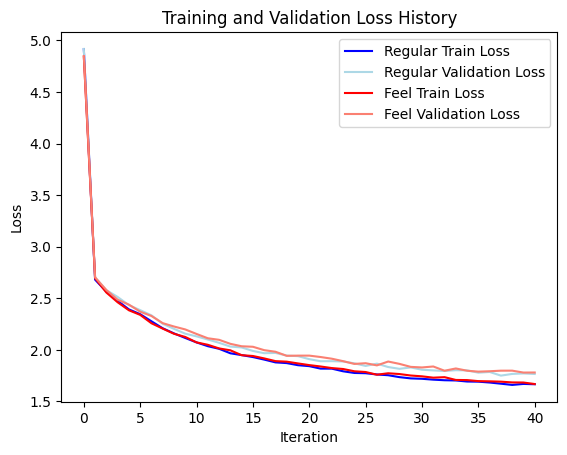

In [11]:
import matplotlib.pyplot as plt

plt.plot(history_regular['train'], label='Regular Train Loss', color='blue')
plt.plot(history_regular['val'], label='Regular Validation Loss', color='lightblue')
plt.plot(history_feel['train'], label='Feel Train Loss', color='red')
plt.plot(history_feel['val'], label='Feel Validation Loss', color='salmon')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.show()